## Exercise 6-3

# Neural Tensor Network (NTN)

In this exercise we will discuss NTN for modeling multi-relational data. So far we have implemented bilinear models and MLP based model. Both types of model are good at capturing certain types of relations. NTN combines MLP with Bilinear-Models thus levearging the best of two worlds.  

The bilinear models are good at capturing linear interactions but are limited in terms of expressive power to capture complex relations. On the other hand MLP based model have hidden layer with non linearity and are good in capturing complex relations. 

Compared to bilinear model NTN has much more expressive power. However, due to large number of parameters it is more prone to overfitting (atleast on small dataset).

NTN replaces a standard linear neural network layer with a bilinear tensor. Thus directly relating two entities across multiple dimensions.

In the following we define NTN to model triples in a given knowledge graph $KG=<e_i,r_k, e_j>$:

$f_{ijk}^{NTN} = r_k^Tg([h_{ijk}^a,h_{ijk}^b])$

$h_{ijk}^{a} = W_k^T[a_{i},a_{j}]$

$h_{ijk}^{b} = [a_i^TB_1^ka_j,......,a_i^TB_{H_b}^k a_j]$

where $B^k$ is a tensor with $H_b$ slices and $h_{ijk}^{b}$ is a bilinear hidden layer.  

$W$ is the hidden representation matrix for each relation. 


Each element of $f_{ijk}^{NTN}$ is a confidence of triple $<e_i,r_k, e_j>$. Similar to previous exercise we can formulate a link prediction problem using binary cross entropy loss function and solve it using gradient based methods:

$L_{ijk} = x_{ijk} log \sigma (f_{ijk}^{NTN}) + (1-x_{ijk}) log \sigma (f_{ijk}^{NTN})$

where $x_{ijk}=1$ if triple $<e_i,r_k,e_j>$ exists and $x_{ijk} = 0$ otherwise.

For evaluations of method we will use the kinship dataset representing 26 relations (brother, sister, father,...} between 104 people. 

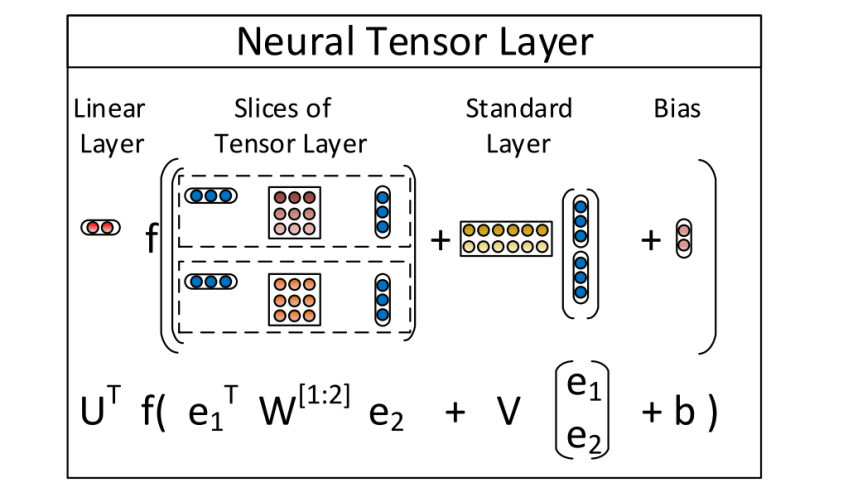

In [1]:
from IPython.display import Image
Image(filename='ntn-layer.png')

In [14]:
import torch.nn as nn
import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from utils import get_minibatches, sample_negatives, accuracy, auc
from time import time

In [15]:
class NTN(nn.Module):
    """
    NTN: Neural Tensor Machine
    --------------------------
    Socher, Richard, et al. "Reasoning with neural tensor networks for knowledge base completion." NIPS, 2013.
    """

    def __init__(self, n_e, n_r, k, H_b, lam, gpu=False):
        """
        NTN: Neural Tensor Network
        --------------------------

        Params:
        -------
            n_e: int
                Number of entities in dataset.

            n_r: int
                Number of relationships in dataset.

            k: int
                Embedding size.

            slice: int
                Number of tensor slices.

            lam: float
                Prior strength of the embeddings. Used to constaint the
                embedding norms inside a (euclidean) unit ball. The prior is
                Gaussian, this param is the precision.

            gpu: bool, default: False
                Whether to use GPU or not.
        """
        super(NTN, self).__init__()

        # Hyperparams
        self.n_e = n_e
        self.n_r = n_r
        self.k = k
        self.H_b = H_b
        self.lam = lam
        self.gpu = gpu

        # Nets
        self.emb_E = nn.Embedding(self.n_e, self.k)
        self.emb_R = nn.Embedding(self.n_r, self.k*self.k*self.H_b)
        self.V = nn.Embedding(self.n_r, 2*self.k*self.H_b)
        self.U = nn.Embedding(self.n_r, self.H_b)
        self.b = nn.Embedding(self.n_r, self.H_b)

        self.embeddings = [self.emb_E, self.emb_R]
        self.initialize_embeddings()

        # Copy all params to GPU if specified
        if self.gpu:
            self.cuda()

    def forward(self, X):
        # Decompose X into head, relationship, tail
        hs, ls, ts = X[:, 0], X[:, 1], X[:, 2]

        if self.gpu:
            hs = Variable(torch.from_numpy(hs).cuda())
            ls = Variable(torch.from_numpy(ls).cuda())
            ts = Variable(torch.from_numpy(ts).cuda())
        else:
            hs = Variable(torch.from_numpy(hs))
            ls = Variable(torch.from_numpy(ls))
            ts = Variable(torch.from_numpy(ts))

        # Project to embedding, broadcasting is a bit convoluted
        e_hs = self.emb_E(hs).view(-1, self.k, 1)
        e_ts = self.emb_E(ts).view(-1, self.k, 1)
 
        Wr = self.emb_R(ls).view(-1, self.H_b, self.k, self.k)
        
        Vr = self.V(ls).view(-1, self.H_b, 2*self.k)
        Ur = self.U(ls).view(-1, 1, self.H_b)
        br = self.b(ls).view(-1, self.H_b, 1)

        # Forward
        # -------

        M = e_hs.size(0)

        # M x s x 1 x 3
        e_hs_ = e_hs.unsqueeze(1).expand(M, self.H_b, self.k, 1).transpose(2, 3)
        # M x s x k x 1
        e_ts_ = e_ts.unsqueeze(1).expand(M, self.H_b, self.k, 1)

        # M x s x 1 x 1
        quad = torch.matmul(torch.matmul(e_hs_, Wr), e_ts_)
        quad = quad.view(-1, self.H_b)  # M x H_b

        # Vr: M x s x 2k
        # [e1 e2]: M x 2k x 1
        es = torch.cat([e_hs, e_ts], dim=1)  # M x 2k x 1
        affine = torch.baddbmm(br, Vr, es).view(-1, self.H_b)  # M x H_b

        # Scores
        g = torch.bmm(Ur, F.leaky_relu(quad + affine).view(-1, self.H_b, 1))

        return g.view(-1, 1)

    def predict(self, X, sigmoid=False):
        """
        Predict the score of test batch.

        Params:
        -------
        X: int matrix of M x 3, where M is the (mini)batch size
            First row contains index of head entities.
            Second row contains index of relationships.
            Third row contains index of tail entities.

        sigmoid: bool, default: False
            Whether to apply sigmoid at the prediction or not. Useful if the
            predicted result is scores/logits.

        Returns:
        --------
        y_pred: np.array of Mx1
        """
        y_pred = self.forward(X).view(-1, 1)

        if sigmoid:
            y_pred = F.sigmoid(y_pred)

        if self.gpu:
            return y_pred.cpu().data.numpy()
        else:
            return y_pred.data.numpy()
    
    def get_embeddings(self):
        entity_embedding = self.embeddings[0].weight.data.numpy()
        relation_embedding = self.embeddings[1].weight.data.numpy()
        return entity_embedding, relation_embedding
        
    def log_loss(self, y_pred, y_true, average=True):
        """
        Compute log loss (Bernoulli NLL).

        Params:
        -------
        y_pred: vector of size Mx1
            Contains prediction logits.

        y_true: np.array of size Mx1 (binary)
            Contains the true labels.

        average: bool, default: True
            Whether to average the loss or just summing it.

        Returns:
        --------
        loss: float
        """
        if self.gpu:
            y_true = Variable(torch.from_numpy(y_true.astype(np.float32)).cuda())
        else:
            y_true = Variable(torch.from_numpy(y_true.astype(np.float32)))

        nll = F.binary_cross_entropy_with_logits(y_pred, y_true, size_average=average)

        norm_E = torch.norm(self.emb_E.weight, 2, 1)
        norm_R = torch.norm(self.emb_R.weight, 2, 1)

        # Penalize when embeddings norms larger than one
        nlp1 = torch.sum(torch.clamp(norm_E - 1, min=0))
        nlp2 = torch.sum(torch.clamp(norm_R - 1, min=0))

        if average:
            nlp1 /= nlp1.size(0)
            nlp2 /= nlp2.size(0)

        return nll + self.lam*nlp1 + self.lam*nlp2

    def ranking_loss(self, y_pos, y_neg, margin=1, C=1, average=True):
        """
        Compute loss max margin ranking loss.

        Params:
        -------
        y_pos: vector of size Mx1
            Contains scores for positive samples.

        y_neg: np.array of size Mx1 (binary)
            Contains the true labels.

        margin: float, default: 1
            Margin used for the loss.

        C: int, default: 1
            Number of negative samples per positive sample.

        average: bool, default: True
            Whether to average the loss or just summing it.

        Returns:
        --------
        loss: float
        """
        M = y_pos.size(0)

        y_pos = y_pos.view(-1).repeat(C)  # repeat to match y_neg
        y_neg = y_neg.view(-1)

        # target = [-1, -1, ..., -1], i.e. y_neg should be higher than y_pos
        target = -np.ones(M*C, dtype=np.float32)

        if self.gpu:
            target = Variable(torch.from_numpy(target).cuda())
        else:
            target = Variable(torch.from_numpy(target))

        loss = F.margin_ranking_loss(
            y_pos, y_neg, target, margin=margin, size_average=average
        )

        return loss

    def normalize_embeddings(self):
        for e in self.embeddings:
            e.weight.data.renorm_(p=2, dim=0, maxnorm=1)

    def initialize_embeddings(self):
        r = 6/np.sqrt(self.k)
        for e in self.embeddings:
            e.weight.data.uniform_(-r, r)
        self.normalize_embeddings()

In [16]:
# Set random seed
randseed = 9999
np.random.seed(randseed)
torch.manual_seed(randseed)

In [17]:
# Data Loading
# Load dictionary lookups
idx2ent = np.load('data/kinship/bin/idx2ent.npy')
idx2rel = np.load('data/kinship/bin/idx2rel.npy')

n_e = len(idx2ent)
n_r = len(idx2rel)

# Load dataset
X_train = np.load('data/kinship/bin/train.npy')
X_val = np.load('data/kinship/bin/val.npy')
y_val = np.load('data/kinship/bin/y_val.npy')

X_val_pos = X_val[y_val.ravel() == 1, :]  # Take only positive samples

M_train = X_train.shape[0]
M_val = X_val.shape[0]

# Model Parameters
k = 50
embeddings_lambda = 0
H_b = n_r
model = NTN(n_e=n_e, n_r=n_r, k=k, H_b=H_b, lam=embeddings_lambda, gpu= False)

In [18]:
normalize_embed = True
C = 10 # Negative Samples
# Optimizer Initialization
nepoch = 20
lr = 0.1
lr_decay_every = 20
solver = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
n_epoch = nepoch
mb_size = 100  # 2x with negative sampling
print_every = 9999
# Begin training
for epoch in range(n_epoch):
    print('Epoch-{}'.format(epoch+1))
    print('----------------')
    it = 0
    # Shuffle and chunk data into minibatches
    mb_iter = get_minibatches(X_train, mb_size, shuffle=True)

    # Anneal learning rate
    lr = lr * (0.5 ** (epoch // lr_decay_every))
    for param_group in solver.param_groups:
        param_group['lr'] = lr

    for X_mb in mb_iter:
        start = time()

        # Build batch with negative sampling
        m = X_mb.shape[0]
        # C x M negative samples
        X_neg_mb = sample_negatives(X_mb, n_e)
        X_train_mb = np.vstack([X_mb, X_neg_mb])

        y_true_mb = np.vstack([np.ones([m, 1]), np.zeros([m, 1])])

        # Training step
        y = model.forward(X_train_mb)
        loss = model.log_loss(y, y_true_mb, average=True)
        
        loss.backward()
        solver.step()
        solver.zero_grad()
        if normalize_embed:
            model.normalize_embeddings()

        end = time()
        # Training logs
        if it % print_every == 0:
            # Training auc
            pred = model.predict(X_train_mb, sigmoid=True)
            train_acc = auc(pred, y_true_mb)
            
            # Per class accuracy
            # pos_acc = accuracy(pred[:m], y_true_mb[:m])
            # neg_acc = accuracy(pred[m:], y_true_mb[m:])

            # Validation auc
            y_pred_val = model.forward(X_val)
            y_prob_val = F.sigmoid(y_pred_val)
            
            val_acc = auc(y_prob_val.data.numpy(), y_val)
            # Validation loss
            val_loss = model.log_loss(y_pred_val, y_val, True)

            print('Iter-{}; loss: {:.4f}; train_auc: {:.4f}; val_auc: {:.4f}; val_loss: {:.4f}; time per batch: {:.2f}s'
                    .format(it, loss.data[0], train_acc, val_acc, val_loss.data[0], end-start))

        it += 1

Epoch-1
----------------
Iter-0; loss: 2.7420; train_auc: 0.5415; val_auc: 0.5309; val_loss: 2.2890; time per batch: 0.09s
Epoch-2
----------------
Iter-0; loss: 0.8103; train_auc: 0.6683; val_auc: 0.6173; val_loss: 0.8826; time per batch: 0.08s
Epoch-3
----------------
Iter-0; loss: 0.7428; train_auc: 0.6710; val_auc: 0.6772; val_loss: 0.7532; time per batch: 0.08s
Epoch-4
----------------
Iter-0; loss: 0.5746; train_auc: 0.7820; val_auc: 0.7385; val_loss: 0.6425; time per batch: 0.10s
Epoch-5
----------------
Iter-0; loss: 0.6095; train_auc: 0.7539; val_auc: 0.7642; val_loss: 0.6124; time per batch: 0.10s
Epoch-6
----------------
Iter-0; loss: 0.5292; train_auc: 0.8177; val_auc: 0.8175; val_loss: 0.5413; time per batch: 0.08s
Epoch-7
----------------
Iter-0; loss: 0.5127; train_auc: 0.8457; val_auc: 0.8646; val_loss: 0.4590; time per batch: 0.08s
Epoch-8
----------------
Iter-0; loss: 0.5037; train_auc: 0.8443; val_auc: 0.8845; val_loss: 0.4304; time per batch: 0.10s
Epoch-9
--------

## Task-1: T-SNE Visualization of Entity and Relation Embeddings

Similar to previous exercise do the t-sne of latent representations. 

In [31]:
###########################
###### Your Code Here
###########################

## Task-2: Link Correction

Split validation set in two parts. Use one as a validation and other as a test set. Use your model to identify correctness of links in test set. Report all triples for which such correction is observed.

In [32]:
###########################
###### Your Code Here
###########################

## Task-3: k-NN for Entity and Relation Set

Similar to ER-MLP exercise report k Nearest Neighbor for all entities and relations. Use cosine distance as a metric.  


## Task-4: WordNet Evaluation

Evaluate NTN on wordnet dataset and report k-NN (k=3) for any 10 random entities. Also do the t-sne plot and investigate whether similar entities are clustered.